In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, timedelta
import matplotlib.gridspec as gridspec
import seaborn as sns
import glob
from PIL import Image
from scipy.stats import spearmanr
from scipy.stats import linregress


In [9]:
# Carregamento dos dados de moblidade e ajustes para processamento 

df1 = pd.read_csv('mobility_510IGR.csv') # entrade de dados de transporte

# Converter todo o DataFrame para strings usando o método astype
df1 = df1.astype(str)

# Converter a coluna 'fluxo' de volta para inteiros
# Primeiro, convertemos para float para lidar com possíveis valores flutuantes formatados como string
df1['fluxo'] = df1['fluxo'].astype(float).astype(np.int64)

# Carregar o DataFrame
df2 = pd.read_csv('popRGI.csv') # entrade de dados de população
display(df2)


df2['rgi'] = df2['rgi'].astype(str)

df2['Population'] = df2['Population'].astype(int)

def Pop(rgi):
    N = df2.loc[df2['rgi'] == rgi, 'Population'].sum()
    return N

,rgi,Population,Municipios
0,110001,666953,5
1,110002,242279,8
2,110003,122216,5
3,110004,313023,13
4,110005,308988,14
...,...,...,...
505,520019,722640,6
506,520020,506355,7
507,520021,140572,14
508,520022,65161,7


In [10]:
#CODIGO PRINCIPAL

def flow(i,j):

    N=Pop(i)

    
    #somatorio dos fluxos destino e origem
    flow_t=sum(map(int,df1.loc[(df1['destino']==j)&(df1['origem']==i)].fluxo)) #fluxo trabalho estudo

    flow= np.array([(flow_t / 52)*((100 + mob[t]-1)/100) for t in range(len(mob))]) #ajusta p escala semanal 
    # fluxo total
    return flow/(N)


gamma=1/5
#g(x)
def g(x,gamma):

    return np.exp(-gamma*x)



#Integral b(t-x)g(x) dx
def Int(b,t,gamma,P=None):

    if P==None:
        P=1

    Int=0

    interval=np.arange(t+1)
    for x in interval:

        Int += b[t-x]*g(x,gamma)

    return P*Int



#sucetivel = população - soma acumulada de infectados
def S(t,i):
    return N[i]-np.cumsum(B[i])[t]

def Q(t,i):

    return B[i][t]/S(t,i)

#definiu para auxiliar na calculo de theta
def Sum_flow(i,t,Mun):

    Sum=0

    for k2 in Mun:
        if k2 != i:
            Sum += flows[i][k2][t]

    return Sum



#determina theta para qualquer municipio
def Theta(t,i,j,Mun):

    if i==j:
        Theta=(1/N[i])*(Int(B[i],t,gamma)*((1-Sum_flow(i,t,Mun))**2))

        for k in Mun:
            if k != i:
                Theta+= (1/N[i])*(Int(B[k],t,gamma)*(1-Sum_flow(i,t,Mun))*flows[k][i][t])


    else:
        Theta=(1/N[j])*(Int(B[i],t,gamma)*(flows[i][j][t]**2)+Int(B[j],t,gamma)*(1-Sum_flow(j,t,Mun))*flows[i][j][t])

        for k in Mun:
            if k != i and k !=j:
                Theta+= (1/N[j])*(flows[i][j][t]*flows[k][j][t]*Int(B[k],t,gamma))



    return Theta





#criando matriz de beta
def Beta(t,Mun):

    Thetas=[]



    for i in Mun:
        sub_th=[]
        for j in Mun:
            sub_th.append(Theta(t,i,j,Mun))

        Thetas.append(sub_th)


    Thetas=np.array(Thetas)



    Qs=np.array([Q(t,i) for i in Mun])



    Betas=np.linalg.solve(Thetas, Qs) #linalg.solve resolver a operação de theta e Q

    Betas_dic={}
    i_uf=0
    for UF in Mun:
        Betas_dic[UF]=Betas[i_uf]


        if Betas[i_uf]<0:
            print(Betas[i_uf])

        i_uf+=1

    return Betas_dic




def Lambda(t,Mun):

    Betas=Beta(t,Mun)

    Lambdas={}
    for i in Mun:
        semi_Lambdas={}
        for j in Mun:

            if i==j:

                Lambda= (Betas[i]/N[i])*((1-Sum_flow(i,t,Mun))**2)

                for k in Mun:
                    if k != i:
                        Lambda+= (Betas[k]/N[k])*(flows[i][k][t]**2)

            else:

                Lambda= (Betas[i]/N[i])*(flows[j][i][t]*(1-Sum_flow(i,t,Mun)))+ (Betas[j]/N[j])*((1-Sum_flow(j,t,Mun))*flows[i][j][t])

                for k in Mun:
                    if k!= i and k!=j:
                        Lambda+= (Betas[k]/N[k])*(flows[i][k][t]*flows[j][k][t])

            semi_Lambdas[j]=Lambda

        Lambdas[i]=semi_Lambdas

    return Lambdas

#estabele um limite de caso para contribuir no resultado
def Mun_check(t,Mun_base,B,limit):

    Mun=[]
    non_Mun=[]
    for UF in Mun_base:
        if np.cumsum(B[UF])[t] > limit:
            Mun.append(UF)
        else:
            non_Mun.append(UF)

    return Mun,non_Mun

# R(t)
def Rt(B,Mun_base,limit):

    #Defining the F matrix array

    #Data

    Rt={}

    for i in Mun_base:
        semi_Rt={}
        for j in Mun_base:
            semi_Rt[j]=[]
        Rt[i]=semi_Rt


    for UF in Mun_base:
        for UF_2 in Mun_base:
            Rt[UF][UF_2].append(np.nan)



    time= np.arange(len(B[Mun_base[0]])-1)+1

    for t in time:

        Mun,non_Mun=Mun_check(t,Mun_base,B,limit)

        for UF in Mun_base:
            for UF_2 in Mun_base:
                if (UF in non_Mun) or (UF_2 in non_Mun):
                    Rt[UF][UF_2].append(np.nan)



        if Mun != []:
            Lambdas=Lambda(t,Mun)
            for i in Mun:
                for j in Mun:
                    Rt[i][j].append(S(t,i)*Lambdas[i][j]/gamma)


        else:
            for i in Mun:
                for j in Mun:
                    Rt[i][j].append(np.nan)





    return Rt







def J(Rt_data,Mun_base):

    J={}


    for i in Mun_base:
        J_semipar={}
        for j in Mun_base:

            J_par=[]
            time= np.arange(len(B[Mun_base[0]]))
            for t in time:

                J_par.append(Rt_data[i][j][t]*Int(B[j],t,gamma,gamma))

            J_semipar[j]=J_par


        J[i]=J_semipar

    return J

In [11]:
#função para rodar codigos principais 
def Run_Net(Mun_l):

    global mob,N,B,flows


    Mun_base=Mun_l[0:]


    df=pd.read_csv('data_PHC_BA.csv') #dados sindromicos APS_IVAS


    dates=df.date.values


    mob=df.Mobility.values
    B={}
    flows={}
    N={}

    for UF in Mun_base:
        B[UF]=df[UF+'_PHC'].values
        N[UF]=Pop(UF)

        semi_flow={}
        for UF_2 in Mun_base:
            if UF_2!=UF:
                semi_flow[UF_2]=flow(UF,UF_2)
            else:
                semi_flow[UF_2]= np.zeros(len(B[UF]))

        flows[UF]=semi_flow


    Rt_data=Rt(B,Mun_base,1) #15 é o que ?
    J_data=J(Rt_data,Mun_base)

    for UF in Mun_base:
        df_Rt = pd.DataFrame(Rt_data[UF], columns=Rt_data[UF].keys())
        df_J = pd.DataFrame(J_data[UF], columns=J_data[UF].keys())

        df_Rt.insert(0, "date", dates, True)
        df_J.insert(0, "date", dates, True)

        df_Rt.to_csv('RSOS/C2/RT_' + UF + ".csv", index = False)
        df_J.to_csv( 'RSOS/C2/J_' + UF + ".csv", index = False)

In [12]:
# Obter todas as regiões únicas no dataframe

# 120001  # Rio Branco, Acre
# 270001  # Maceió, Alagoas
# 160001  # Macapá, Amapá
# 130001  # Manaus, Amazonas
# 290001  # Salvador, Bahia
# 230001  # Fortaleza, Ceará
# 530001  # Brasília, Distrito Federal
# 320001  # Vitória, Espírito Santo
# 520001  # Goiânia, Goiás
# 210001  # São Luís, Maranhão
# 510001  # Cuiabá, Mato Grosso
# 500001  # Campo Grande, Mato Grosso do Sul
# 310001  # Belo Horizonte, Minas Gerais
# 150001  # Belém, Pará
# 250001  # João Pessoa, Paraíba
# 410001  # Curitiba, Paraná
# 260001  # Recife, Pernambuco
# 220001  # Teresina, Piauí
# 330001  # Rio de Janeiro, Rio de Janeiro
# 240001  # Natal, Rio Grande do Norte
# 430001  # Porto Alegre, Rio Grande do Sul
# 110001  # Porto Velho, Rondônia
# 140001  # Boa Vista, Roraima
# 420001  # Florianópolis, Santa Catarina
# 350001  # São Paulo, São Paulo
# 280001  # Aracaju, Sergipe
# 170001  # Palmas, Tocantins


In [13]:
#listas 
 
list_rgi_BA = sorted(['290001', '290002', '290003', '290004', '290005', '290006', '290007', '290008', '290009', '290010', '290011',
                      '290012', '290013', '290014', '290015', '290016', '290017', '290018', '290019', '290020', '290021', '290022',
                      '290023', '290024', '290025', '290026', '290027', '290028', '290029', '290030', '290031', '290032', '290033', '290034'])

list_c1_BA = sorted(['290001', '290033', '290025', '290029', '290027', '290002','290032', '290023', 
                    '290030', '290028', '290026', '290022'])

list_c2_BA = sorted(['290003', '290004', '290012', '290014', '290005', '290006','290007', 
                    '290008', '290009', '290010'])

list_c3_BA = sorted(['290011', '290013', '290016', '290017', '290018', '290034','290021', '290020', 
                    '290031', '290015', '290019'])



In [14]:
%%time
# Função roda para executar o progrma 

Run_Net(list_c2_BA) #executa lista especifica

-0.000293038413092557
CPU times: user 8min 20s, sys: 2min 11s, total: 10min 32s
Wall time: 1min 52s


# Processamenteo dos resultados
> processo de analises e vizualizações


In [15]:
#matriz de espalhamento 

import numpy as np
import pandas as pd
import glob
### faz o calculo usando casos como fator de normalização 
df = pd.read_csv('data_PHC_BA.csv')

path = 'RSOS/C2/'
files = glob.glob(path + 'J_*.csv')

# Cria um dicionário para armazenar os resultados
J_m = {}

# Itera sobre cada código de município (j)
for j in list_c2_BA: ### MUDAR LISTA (c1, c2, c3)
    J_list = []
    
    # Itera sobre cada município (i) 
    for i in list_c2_BA:   ### MUDAR LISTA (c1, c2, c3)
        # Carrega o arquivo correspondente ao município i
        file = next((f for f in files if 'J_' + str(i) in f), None)
        if file:
            B = df[str(i) + '_PHC'].values  # Carrega os casos para o município i
            df_J = pd.read_csv(file)     # Carrega o arquivo de interação J_ij
            J_ij = df_J[str(j)].values   # Seleciona a coluna correspondente ao código j
            
            # Remove valores NaN de J_ij
            J_ij_n = J_ij[~np.isnan(J_ij)]
            
            # Verificação antes da divisão
            if len(J_ij_n) == 0:
                print(f"J_ij_n vazio para o município {i} com código {j}")
                J_list.append(np.nan)
            else:
                valid_B = B[len(J_ij) - len(J_ij_n):]
                non_zero_indices = valid_B != 0
                
                if np.any(non_zero_indices):
                    valid_ratio = J_ij_n[non_zero_indices] / valid_B[non_zero_indices]
                    J_list.append(100 * np.mean(valid_ratio))
                else:
                    print(f"Divisão por zero em B para o município {i} com código {j}")
                    J_list.append(np.nan)
    
    # Atualiza o dicionário com o código do município j como chave
    J_m[j] = J_list

# Cria um DataFrame pandas a partir do dicionário de resultados
df_m = pd.DataFrame.from_dict(J_m)

# Transpõe o DataFrame para ter os códigos como índices
df_m['Code'] = list(df_m.columns)
df_m.set_index('Code', inplace=True)

# Normaliza as linhas para somar 100% (se necessário)
soma_linha = df_m.sum(axis=1)
df_norm = df_m.div(soma_linha, axis=0) * 100

# Substituir NaN por 0
df_norm = df_norm.fillna(0)

# Formatar para duas casas decimais
df_norm = df_norm.round(2)

# Exibe o DataFrame formatado
display(df_norm)

# Salva o DataFrame em um arquivo CSV
df_norm.to_csv(f'RSOS/C2/matriz_J%_semana_BA_c2.csv')


,290003,290004,290005,290006,290007,290008,290009,290010,290012,290014
Code,,,,,,,,,,
290003,95.15,1.24,0.34,0.51,0.20,0.08,0.07,0.08,1.87,0.45
290004,4.38,90.23,1.79,0.29,0.49,0.11,0.11,0.08,1.23,1.30
290005,0.83,1.22,92.13,1.75,1.15,0.04,0.20,0.20,0.52,1.97
290006,1.89,0.30,2.66,93.96,0.48,0.00,0.08,0.04,0.32,0.26
290007,0.25,0.17,0.60,0.16,94.86,0.39,0.47,1.21,0.41,1.48
290008,0.03,0.01,0.01,0.00,0.10,99.23,0.39,0.18,0.00,0.04
290009,0.08,0.03,0.09,0.03,0.45,1.35,96.72,0.98,0.06,0.20
290010,0.05,0.01,0.05,0.01,0.59,0.35,0.50,97.96,0.11,0.38
290012,2.37,0.43,0.27,0.11,0.41,0.00,0.07,0.22,94.02,2.09


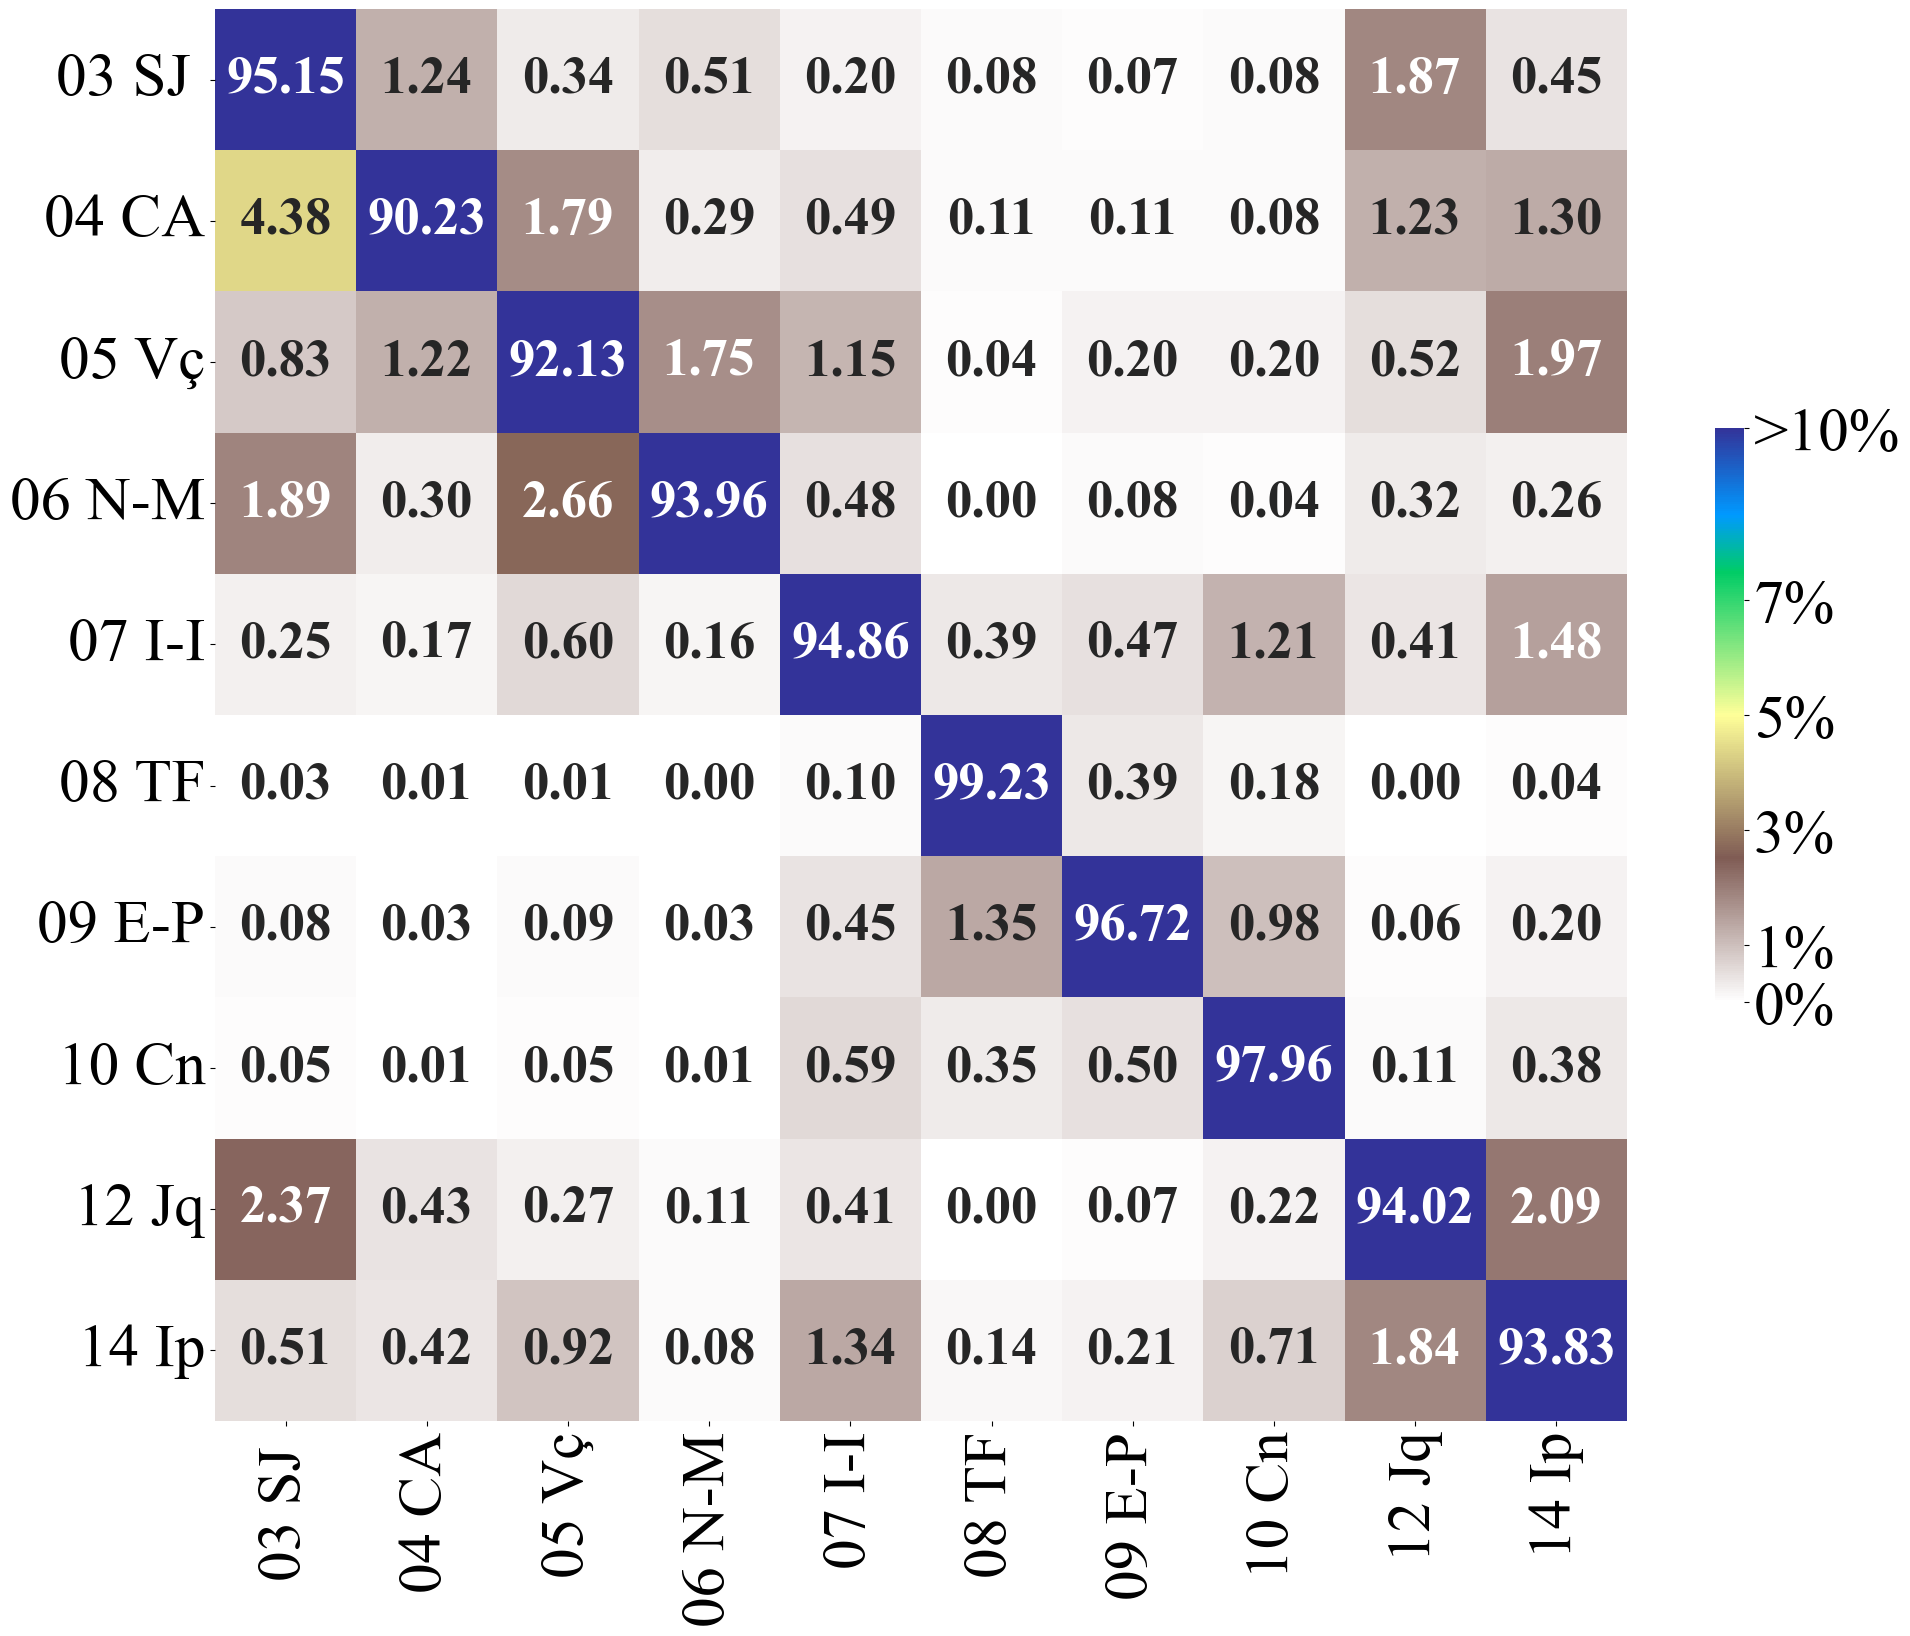

In [16]:
# Carregar o arquivo CSV para um DataFrame

plt.rcParams['font.family'] = 'Times New Roman'
df = pd.read_csv('RSOS/C2/matriz_J%_semana_BA_c2.csv') #dados de entrada: matriz de espalhamento 
df.set_index(df.columns[0], inplace=True)

#display(df)


# Dicionário para mapear códigos para nomes de regiões imediatas
codigos_regioes_imediatas = {
    290001: "Salvador (1)",
    290002: "Alagoinhas (2)",
    290003: "Santo Antônio de Jesus (3) ",
    290004: "Cruz das Almas (4)",
    290005: "Valença (5)",
    290006: "Nazaré – Maragogipe (6)",
    290007: "Ilhéus – Itabuna (7)",
    290008: "Teixeira de Freitas(8)",
    290009: "Eunápolis - Porto Seguro(9)",
    290010: "Camacan(10)",
    290011: "Vitória da Conquista(11)",
    290012: "Jequié (12)",
    290013: "Brumado (13)",
    290014: "Ipiaú (14)",
    290015: "Itapetinga (15)",
    290016: "Guanambi (16)",
    290017: "Bom Jesus da Lapa (17)",
    290018: "Barreiras (18)",
    290019: "Santa Maria da Vitoria (19)",
    290020: "Irecê (20)",
    290021: "Xique-Xique – Barra (21)",
    290022: "Juazeiro (22)",
    290023: "Senhor do Bonfim (23)",
    290024: "Paulo Afonso (24)",
    290025: "Ribeira do Pombal (25)",
    290026: "Euclides da Cunha (26)",
    290027: "Cícero Dantas (27)",
    290028: "Jeremoabo (28)",
    290029: "Feira de Santana (29)",
    290030: "Jacobina (30)",
    290031: "Itaberaba (31)",
    290032: "Conceição do Coité (32)",
    290033: "Serrinha (33)",
    290034: "Seabra (34)"
}

codigos_regioes_imediatas_abr = {
    290001: "01 Sa",
    290002: "02 Al",
    290003: "03 SJ ",
    290004: "04 CA",
    290005: "05 Vç",
    290006: "06 N-M",
    290007: "07 I-I",
    290008: "08 TF",
    290009: "09 E-P",
    290010: "10 Cn",
    290011: "11 VC",
    290012: "12 Jq",
    290013: "13 Bd",
    290014: "14 Ip",
    290015: "15 Ig",
    290016: "16 Gb",
    290017: "17 BJ",
    290018: "18 Br",
    290019: "19 SM",
    290020: "20 Ic",
    290021: "21 X-B",
    290022: "22 Jz",
    290023: "23 SB",
    290024: "24 PA",
    290025: "25 RP",
    290026: "26 EC",
    290027: "27 CD",
    290028: "28 Jm",
    290029: "29 FS",
    290030: "30 Jb",
    290031: "31 Ib",
    290032: "32 CC",
    290033: "33 Sr",
    290034: "34 Sb"
}

# Mapear índices e colunas para nomes usando o dicionário
#df.index = [codigos_regioes_imediatas.get(int(idx), idx) for idx in df.index]
#df.columns = [codigos_regioes_imediatas.get(int(col), col) for col in df.columns]
df.index = [codigos_regioes_imediatas_abr.get(int(idx), idx) for idx in df.index]
df.columns = [codigos_regioes_imediatas_abr.get(int(col), col) for col in df.columns]


# Calcular o módulo dos valores do DataFrame
df = df.abs()

# Definir o tamanho e layout do plot
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = plt.subplot(gs[0, 0])

# Criar o heatmap
h1 = sns.heatmap(df, cmap='terrain_r', annot=True, fmt=".2f",
                 annot_kws={'size': 38, 'weight': 'bold'}, cbar=True, square=True,
                 cbar_kws={"shrink": 0.3}, vmin=0, vmax=10, ax=ax1)

# Configurar o colorbar
#cbar = h1.collections[0].colorbar
#cbar.set_ticks([0, 10, 40, 80, 100])
#cbar.set_ticklabels(['0%', '10%', '40%', '80%', '100%'])

# Configurar o colorbar
cbar = h1.collections[0].colorbar
cbar.set_ticks([0,1,3,5,7, 10 ])
cbar.set_ticklabels(['0%', '1%', '3%', '5%','7%', '>10%'])

# Configurar parâmetros dos eixos e labels
ax1.tick_params(labelsize=44)
cbar.ax.tick_params(labelsize=44)
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)

#ax1.set_ylabel('Matriz de Espalhamento com Fluxo Rodoviário Semanal', fontsize=22)

# Ajustar layout
plt.tight_layout()

# Salvar e mostrar o plot
plt.savefig("RSOS/C2/M_J%C2.png")
plt.show()


In [17]:
## matriz de espalhamento em numeros interos 

import numpy as np
import pandas as pd
import glob
import os

# Carrega os dados
path = 'RSOS/C2'
files = glob.glob(os.path.join(path, 'J_*.csv'))

# Lista de municípios (deve ser definida antes)
list_rgi_BA = sorted([int(os.path.basename(f).split('_')[1].split('.')[0]) for f in files if os.path.basename(f).split('_')[1].split('.')[0].isdigit()])

# Dicionário para armazenar os resultados
J_m = {}

# Itera sobre cada código de município em list_c2_BA
for j in list_c2_BA:
    J_list = []
    
    for i in list_c2_BA:
        # Verifica se o arquivo correspondente existe
        file = next((f for f in files if f'J_{i}.csv' in f), None)
        if file is None:
            print(f"Arquivo J_{i}.csv não encontrado. Pulando...")
            J_list.append(np.nan)
            continue
        
        # Carrega os dados
        df_J = pd.read_csv(file)
        
        # Verifica se a coluna j está presente
        if str(j) not in df_J.columns:
            print(f"Coluna {j} ausente no arquivo {file}. Pulando...")
            J_list.append(np.nan)
            continue
        
        # Obtém os valores de J_ij
        J_ij = pd.to_numeric(df_J[str(j)], errors='coerce').dropna().values
        
        if len(J_ij) == 0:
            print(f"J_ij vazio para o município {i} com código {j}")
            J_list.append(np.nan)
        else:
            J_list.append(int(round(np.mean(J_ij))))
    
    # Atualiza o dicionário com o código do município j como chave
    J_m[j] = J_list

# Cria o DataFrame com os resultados
df_m = pd.DataFrame.from_dict(J_m, orient='index', columns=list_c2_BA)
df_m = df_m.reindex(sorted(df_m.index))  # Ordena as linhas

df_m.fillna(0, inplace=True)  # Substituir NaN por 0
df_m = df_m.astype(int)  # Converter os valores para inteiros
np.fill_diagonal(df_m.values, 0)

# Salva o DataFrame final
df_m.to_csv(os.path.join(path,'matriz_J_semana_BA_c2.csv'))

# Exibir o DataFrame
display(df_m)

,290003,290004,290005,290006,290007,290008,290009,290010,290012,290014
290003,0,10,2,3,1,0,0,0,10,2
290004,5,0,3,1,1,0,0,0,2,1
290005,1,4,0,5,3,0,0,0,1,3
290006,2,1,4,0,1,0,0,0,0,0
290007,1,1,3,1,0,1,2,2,2,4
290008,0,0,0,0,2,0,6,1,0,0
290009,0,0,1,0,3,3,0,2,0,1
290010,0,0,1,0,8,2,4,0,1,2
290012,7,3,1,1,2,0,0,0,0,6
290014,2,3,5,0,9,0,1,1,9,0


In [28]:
import pandas as pd
import numpy as np
import glob
#### Gera arquivos para grafico de barras por comunidade ######
# Caminho para os arquivos J
path = 'RSOS/C2/'
files = glob.glob(path + 'J_*.csv')

print(f"Total de arquivos CSV encontrados: {len(files)}")

# Carregando dados adicionais
df_fluxo = pd.read_csv('mobility_510IGR.csv')  # Dados de fluxo anual

# Convertendo df_fluxo para um dicionário para acelerar a busca
df_fluxo['destino'] = df_fluxo['destino'].astype(str)
df_fluxo['origem'] = df_fluxo['origem'].astype(str)
fluxo_dict = df_fluxo.set_index(['origem', 'destino'])['fluxo'].to_dict()

# Estruturas para armazenar os dados processados
J_1 = {}
F = {}

# Processando apenas arquivos da lista `list_c2_BA`
for file in files:
    rgi_code = file.split('/')[-1].split('_')[-1].split('.')[0]  # Extrai o código RGI do nome do arquivo
    
    # Ignorar arquivos que não estão na lista
    if rgi_code not in list_c2_BA:
        continue

    df_J = pd.read_csv(file)

    J_list_1 = []
    F_list = []

    # Processando apenas colunas da lista `list_c2_BA`
    for j in list_c2_BA:
        if j in df_J.columns:
            J_ij = df_J[j].values
        else:
            J_ij = np.zeros(len(df_J.index))  # Zero para RGIs faltantes

        if rgi_code == j:
            J_ij = np.zeros(len(J_ij))  # Garante que a diagonal seja zerada

        J_ij_n = J_ij[~np.isnan(J_ij)]
        J_list_1.append(np.sum(J_ij_n))

        # Busca otimizada no dicionário em vez do DataFrame inteiro
        flow_t = fluxo_dict.get((rgi_code, j), 0)
        F_list.append(flow_t)

    J_1[rgi_code] = J_list_1
    F[rgi_code] = F_list

# Criando DataFrames a partir dos dicionários
df_1 = pd.DataFrame.from_dict(J_1, orient='index', columns=list_c2_BA)
df_1['sum'] = df_1.sum(axis=1)

df_1['average'] = df_1['sum'] / 7

df_fl = pd.DataFrame.from_dict(F, orient='index', columns=list_c2_BA)
df_fl['sum'] = df_fl.sum(axis=1)

# Concatenando os dados de SIR e movimento para comparação
data = [df_1['average'], df_fl['sum']]
headers = ['SIR', 'Movement']
df_f = pd.concat(data, axis=1, keys=headers)

# Arredondando valores para zero casas decimais
df_f["SIR"] = df_f["SIR"] / 52
df_f["Movement"] = df_f["Movement"] / 52
df_f = df_f.round(0).astype(int)

# Exibindo os resultados finais
print(df_f)
df_f.to_csv(f'RSOS/C2/dados_grafico_barraC2.csv')

print("Processing completed.")


Total de arquivos CSV encontrados: 10
        SIR  Movement
290012   24      8802
290006   11      4567
290007   31      9327
290005   20      8764
290010    6      2793
290004   22      8205
290014   19      8963
290003   20      9652
290009   15      4101
290008    7      2560
Processing completed.


/var/folders/ms/1wk5h_rx0_j34hqrcp2klhc00000gn/T/ipykernel_1400/3975344976.py:84: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 500000)


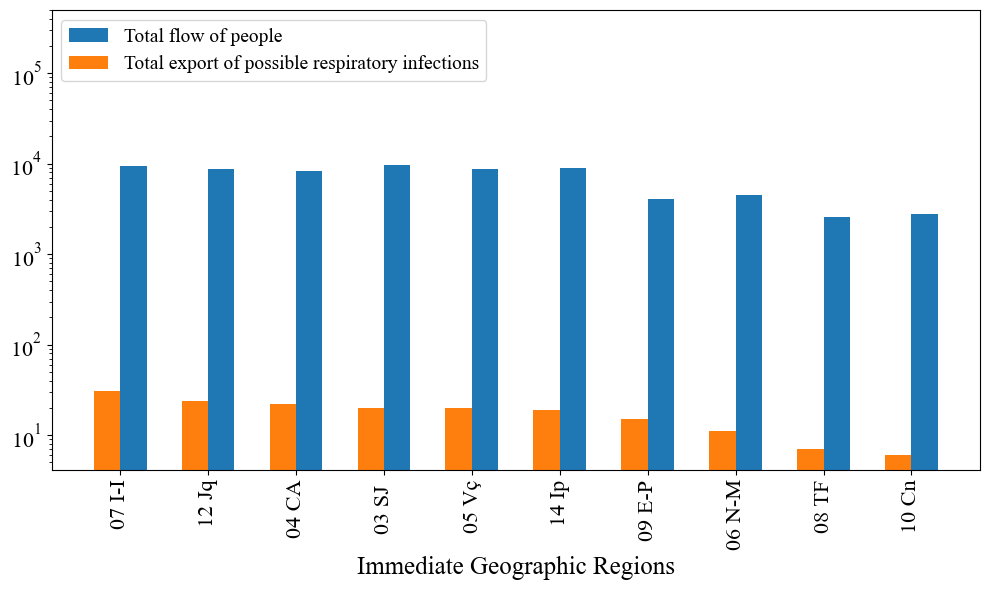

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Dicionário de códigos abreviados
codigos_abr = {
    290001: "01 Sa",
    290002: "02 Al",
    290003: "03 SJ ",
    290004: "04 CA",
    290005: "05 Vç",
    290006: "06 N-M",
    290007: "07 I-I",
    290008: "08 TF",
    290009: "09 E-P",
    290010: "10 Cn",
    290011: "11 VC",
    290012: "12 Jq",
    290013: "13 Bd",
    290014: "14 Ip",
    290015: "15 Ig",
    290016: "16 Gb",
    290017: "17 BJ",
    290018: "18 Br",
    290019: "19 SM",
    290020: "20 Ic",
    290021: "21 X-B",
    290022: "22 Jz",
    290023: "23 SB",
    290024: "24 PA",
    290025: "25 RP",
    290026: "26 EC",
    290027: "27 CD",
    290028: "28 Jm",
    290029: "29 FS",
    290030: "30 Jb",
    290031: "31 Ib",
    290032: "32 CC",
    290033: "33 Sr",
    290034: "34 Sb"
}

# Ordenando o DataFrame pelas RGIs
df_f.sort_index(inplace=True)
df_f.sort_values(by="SIR", ascending=False, inplace=True)

# Supondo que df_f seja o seu DataFrame e já contenha as colunas 'SIR' e 'Movement'
rgis = df_f.index  # Os nomes dos RGIs
sir_values = df_f['SIR']  # Dados de SIR
movement_values = df_f['Movement']  # Dados de Movement

# Garantindo que os índices do DataFrame sejam tratados como inteiros
rgis = df_f.index.astype(int)

# Mapeando os índices para os nomes abreviados
labels = [codigos_abr.get(rgi, f"Sem Nome {rgi}") for rgi in rgis]

# Número de RGIs
n_rg = len(rgis)

# Configurando as posições das barras
ind = np.arange(n_rg)  # as posições x dos grupos
width = 0.3  # a largura das barras

fig, ax = plt.subplots(figsize=(10, 6))  

# Criando barras para Movement
movement_bars = ax.bar(ind + width/2, movement_values, width, label='Total flow of people')

# Criando barras para SIR
sir_bars = ax.bar(ind - width/2, sir_values, width, label='Total export of possible respiratory infections')

# Adicionando rótulos, título e legendas personalizados
ax.set_xlabel('Immediate Geographic Regions', fontsize=18)
ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation=90, fontsize=16)  # Rotaciona os rótulos para ficarem legíveis
ax.legend()

ax.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=14) 

# Configurações adicionais
ax.set_yscale('log')  # Ajusta o eixo y para escala logarítmica
ax.set_ylim(0, 500000)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()

# Mostrando o gráfico
plt.savefig("RSOS/C2/TxR.png", dpi=400)
plt.show()


